In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

drive = '/floyd/input/dogbreeddata'  
path = drive+'/dogImages/'
  
train_files, train_targets = load_dataset(path+'train')
valid_files, valid_targets = load_dataset(path+'valid')
test_files, test_targets = load_dataset(path+'test')

dog_names = [item[20:-1] for item in sorted(glob(path+"train/*/"))]

# Let's check the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8352 total dog images.

There are 6681 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [3]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:12<00:00, 66.73it/s]


In [4]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as preprocess_input_vgg19
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50

def extract_VGG19(file_paths):
    tensors = paths_to_tensor(file_paths).astype('float32')
    preprocessed_input = preprocess_input_vgg19(tensors)
    return VGG19(weights='imagenet', include_top=False).predict(preprocessed_input, batch_size=32)

def extract_Resnet50(file_paths):
    tensors = paths_to_tensor(file_paths).astype('float32')
    preprocessed_input = preprocess_input_resnet50(tensors)
    return ResNet50(weights='imagenet', include_top=False).predict(preprocessed_input, batch_size=32)

In [5]:
train_vgg19 = extract_VGG19(train_files)
valid_vgg19 = extract_VGG19(valid_files)
test_vgg19 = extract_VGG19(test_files)
print("VGG19 shape", train_vgg19.shape[1:])

train_resnet50 = extract_Resnet50(train_files)
valid_resnet50 = extract_Resnet50(valid_files)
test_resnet50 = extract_Resnet50(test_files)
print("Resnet50 shape", train_resnet50.shape[1:])

100%|██████████| 6681/6681 [01:52<00:00, 59.63it/s]


80142336/80134624 [==============================] - 4s 0us/step


  0%|          | 8/6681 [00:00<01:27, 76.67it/s]

VGG19 shape (7, 7, 512)


100%|██████████| 6681/6681 [01:52<00:00, 59.43it/s]
/usr/local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 5s 0us/step


100%|██████████| 836/836 [00:12<00:00, 66.07it/s]


Resnet50 shape (7, 7, 2048)


In [6]:
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers import Input, Dense
from keras.layers.core import Dropout, Activation
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.models import Model

def input_branch(input_shape=None):
    
    size = int(input_shape[2] / 4)
    
    branch_input = Input(shape=input_shape)
    branch = GlobalAveragePooling2D()(branch_input)
    branch = Dense(size, use_bias=False, kernel_initializer='uniform')(branch)
    branch = BatchNormalization()(branch)
    branch = Activation("relu")(branch)
    return branch, branch_input

vgg19_branch, vgg19_input = input_branch(input_shape=train_vgg19.shape[1:])
resnet50_branch, resnet50_input = input_branch(input_shape=train_resnet50.shape[1:])
concatenate_branches = Concatenate()([vgg19_branch, resnet50_branch])
net = Dropout(0.3)(concatenate_branches)
net = Dense(640, use_bias=False, kernel_initializer='uniform')(net)
net = BatchNormalization()(net)
net = Activation("relu")(net)
net = Dropout(0.3)(net)
net = Dense(133, kernel_initializer='uniform', activation="softmax")(net)

model = Model(inputs=[vgg19_input, resnet50_input], outputs=[net])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 7, 7, 2048)   0                                            
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 512)          0           input_7[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 2048)         0           input_8[0][0]                    
__________________________________________________________________________________________________
dense_1 (D

In [9]:
model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='saved_models/bestmodel.hdf5', 
                               verbose=1, save_best_only=True)


In [10]:
history = model.fit([train_vgg19, train_resnet50], train_targets, 
          validation_data=([valid_vgg19, valid_resnet50], valid_targets),
          epochs=10, batch_size=4, callbacks=[checkpointer], verbose=1)

Train on 6681 samples, validate on 835 samples
Epoch 1/10
6681/6681 [==============================] - 19s 3ms/step - loss: 1.5929 - acc: 0.5544 - val_loss: 0.7617 - val_acc: 0.7545

Epoch 00001: val_loss improved from inf to 0.76169, saving model to saved_models/bestmodel.hdf5
Epoch 2/10
6681/6681 [==============================] - 17s 3ms/step - loss: 1.3422 - acc: 0.6224 - val_loss: 0.6731 - val_acc: 0.7868

Epoch 00002: val_loss improved from 0.76169 to 0.67305, saving model to saved_models/bestmodel.hdf5
Epoch 3/10
6681/6681 [==============================] - 17s 3ms/step - loss: 1.2004 - acc: 0.6605 - val_loss: 0.6181 - val_acc: 0.7964

Epoch 00003: val_loss improved from 0.67305 to 0.61808, saving model to saved_models/bestmodel.hdf5
Epoch 4/10
6681/6681 [==============================] - 18s 3ms/step - loss: 1.1192 - acc: 0.6876 - val_loss: 0.6228 - val_acc: 0.7976

Epoch 00004: val_loss did not improve from 0.61808
Epoch 5/10
6681/6681 [==============================] - 17s 3m

In [11]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [12]:
model.load_weights('saved_models/bestmodel.hdf5')

from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report

predictions = model.predict([test_vgg19, test_resnet50])
breed_predictions = [np.argmax(prediction) for prediction in predictions]
breed_true_labels = [np.argmax(true_label) for true_label in test_targets]
print('Test accuracy: %.4f%%' % (accuracy_score(breed_true_labels, breed_predictions) * 100))
# print('Precision: %.4f%%' % (precision_score(breed_true_labels, breed_predictions)))
# print('f1_score: %.4f%%' % (f1_score(breed_true_labels, breed_predictions))) 
# print(precision_recall_fscore_support(breed_true_labels, breed_predictions))
report = classification_report(breed_true_labels, breed_predictions)
print(report)

Test accuracy: 81.6986%
             precision    recall  f1-score   support

          0       1.00      0.75      0.86         8
          1       0.86      0.75      0.80         8
          2       0.75      1.00      0.86         6
          3       1.00      0.75      0.86         8
          4       0.91      1.00      0.95        10
          5       1.00      0.88      0.93         8
          6       0.78      1.00      0.88         7
          7       0.89      1.00      0.94         8
          8       0.50      0.50      0.50         4
          9       0.75      1.00      0.86         6
         10       1.00      1.00      1.00         9
         11       1.00      0.78      0.88         9
         12       1.00      0.33      0.50         6
         13       0.75      1.00      0.86         9
         14       1.00      0.80      0.89        10
         15       1.00      0.75      0.86         8
         16       0.80      1.00      0.89         8
         17       1.0

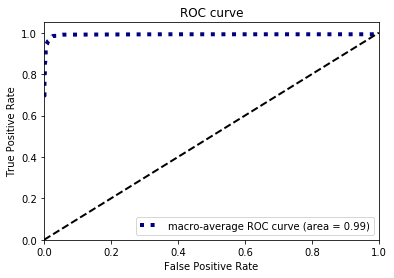

In [62]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw=2
    
    # prepare for figure

    # for both classification tasks (categories 1 and 2)
    for i in range(1,len(dog_names)):
        # obtain ROC curve
        fpr[i], tpr[i], threshold = roc_curve(y_true[:,i], y_pred[:,i],pos_label=1)
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(1,len(dog_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(1,len(dog_names)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(dog_names)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
#     plt.plot(fpr["micro"], tpr["micro"],
#              label='micro-average ROC curve (area = {0:0.2f})'
#                    ''.format(roc_auc["micro"]),
#              color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#     for i, color in zip(range(1,len(dog_names)), colors):
#         plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#                  label='ROC curve of class {0} (area = {1:0.2f})'
#                  ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
plot_roc_auc(test_targets,predictions)